In [20]:
from __future__ import division
import numpy as np
import math
import yaml
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm_notebook
sns.set_style('whitegrid')
%matplotlib inline
import copy

In [21]:
class NetworkP:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1+1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))

        
class NetworkPv:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))


        
        
def find_time_step(schedule_lengths, upper_bound):
    """
    schedule_lengths: tuple of the form (length1, length2)
    upper_bound: the upper bound of the time step size
    """    
    d = math.gcd(*schedule_lengths)
    delta = d / math.ceil(d/upper_bound)
    discrete_schedule_lengths = [s / delta for s in schedule_lengths]
    return delta, discrete_schedule_lengths

In [22]:
def obtain_transition_matrices(n, mu, r11, L, schedule_lengths):
    N, Nv = NetworkP(n, mu, r11, L), NetworkPv(n, 0, r11, L)
    upper_bound = N.get_time_step_upper_bound()
    delta, discrete_schedule_lengths = find_time_step(schedule_lengths, upper_bound)
    
    N.discretise_transition_matrix(time_step=delta)
    P = N.discrete_transition_matrix
    
    Nv.discretise_transition_matrix(delta)
    Pv = Nv.discrete_transition_matrix
    

    return P, Pv, discrete_schedule_lengths, delta

In [23]:
def obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .9999):
    P, Pv, discrete_schedule_lengths, delta = obtain_transition_matrices(n, mu, r11, L, schedule_lengths)
    
    step_counts = [0, 1]
    approx_cdf = [0, P[0, -1]]
    approx_pdf = [0, P[0, -1]]
    transition_matrix = P
    step = 1
    
    while approx_cdf[-1] < stopping_probability:
        step += 1
        if step % sum(discrete_schedule_lengths) < discrete_schedule_lengths[0]:
            transition_matrix = np.matmul(transition_matrix, P)
        else:
            transition_matrix = np.matmul(transition_matrix, Pv)
        step_counts.append(step)
        absorption_prob = transition_matrix[0, -1]
        approx_cdf.append(absorption_prob)
        approx_pdf.append(approx_cdf[-1] - approx_cdf[-2])
    
    pdf = [p / sum(approx_pdf) for p in approx_pdf]
    cdf = np.cumsum(pdf)
    time_steps = [s * delta for s in step_counts]
    return time_steps, pdf, cdf

In [24]:
def mean_time_till_deadlock(n, mu, r11, L, schedule_lengths, stopping_probability = .999):
    time_steps, pdf, cdf = obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .9999)
    return sum([step * prob for step, prob in zip(time_steps, pdf)])

In [25]:
n, mu, r11, L = 6, 4, .2, 2
s = 10
sv = 5

In [26]:
variables = [0.2, 0.4, 0.6, 0.8, 1.0]

time_steps_dict = {}
pdf_dict = {}
cdf_dict = {}

for var in variables:
    time_steps_dict[var], pdf_dict[var], cdf_dict[var] = obtain_probability_distributions(n, mu, var, mu, (s, sv), stopping_probability = .9999)

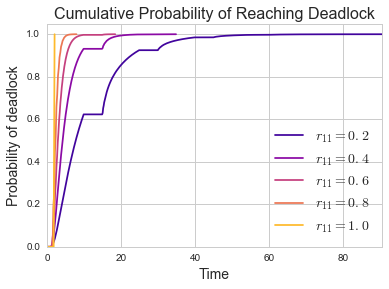

In [27]:
plt.figure()
colours = [cm.plasma(x) for x in np.linspace(0.1, 0.85, len(variables))]

for i in range(len(variables)):
    plt.plot(time_steps_dict[variables[i]], cdf_dict[variables[i]], c=colours[i], label=r"$r_{11} = " + str(variables[i]) + "$")

plt.xlabel("Time", fontsize=14)
plt.xlim(time_steps_dict[0.2][0], time_steps_dict[0.2][-1])
# plt.xlim(0, 520)
plt.ylabel("Probability of deadlock", fontsize="14")
plt.ylim(0, 1.05)
plt.title("Cumulative Probability of Reaching Deadlock", fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.show()

# Matrix Exponential Method

In [28]:
from scipy import linalg

In [29]:
n, mu, r11, L = 6, 4, .2, 2
s = 10
sv = 5

In [30]:
Q = NetworkP(n, mu, r11, L)
Qv = NetworkPv(n, 0, r11, L)

In [31]:
dt = min(Q.get_time_step_upper_bound(), Qv.get_time_step_upper_bound())

In [32]:
cdf_d = [0.0]
times_d = [0.0]
t = 0.0
prev_P = copy.deepcopy(Q.discrete_transition_matrix)
while cdf_d[-1] < 0.999:
    t += dt
    times_d.append(t)
    if t % (s + sv) <= s:
        prev_P = np.matmul(prev_P, Q.discrete_transition_matrix)
    else:
        prev_P = np.matmul(prev_P, Qv.discrete_transition_matrix)
    cdf_d.append(prev_P[0, -1])
cdf_dnorm = [i/cdf_d[-1] for i in cdf_d]

In [33]:
cdf_c = [0.0]
times_c = [0.0]
t = 0.0
prev_P =linalg.expm(Q.transition_matrix*0)
while cdf_c[-1] < 0.999:
    t += dt
    times_c.append(t)
    if t % (s + sv) <= s:
        prev_P = np.matmul(prev_P, linalg.expm(Q.transition_matrix*dt))
    else:
        prev_P = np.matmul(prev_P, linalg.expm(Qv.transition_matrix*dt))
    cdf_c.append(prev_P[0, -1])
cdf_cnorm = [i/cdf_c[-1] for i in cdf_c]

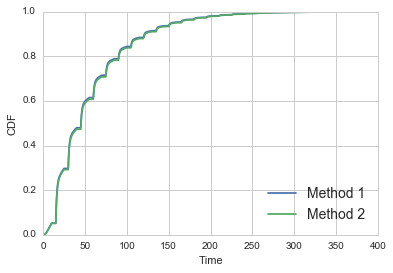

In [34]:
plt.plot(times_d, cdf_d, label='Method 1')
plt.plot(times_c, cdf_c, label='Method 2')
plt.legend(fontsize=14, loc=4)
plt.xlabel('Time')
plt.ylabel('CDF')
plt.savefig("tex/img/method1method2_sametimestep.pdf")

In [35]:
diffs = [cdf_d[i] - cdf_c[i] for i in range(min(len(times_d), len(times_c)))]

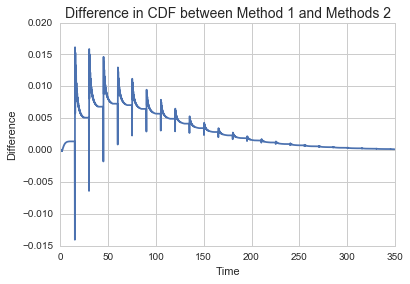

In [36]:
plt.plot(times_d, diffs)
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Difference in CDF between Method 1 and Methods 2', fontsize=14)
plt.savefig("tex/img/method1method2_sametimestep_diffs.pdf")

In [37]:
ts = [0, 10, 15, 25, 30, 40, 45, 55, 60, 70, 75, 85, 90, 100, 105, 115, 120, 130, 135, 145, 150, 160, 165, 175, 180, 185, 195, 200]
ts_act = [0] + [ts[i]-ts[i-1] for i in range(1, len(ts))]

cdf_c = [0.0]
times_c = [0.0]
t = 10
period = 's'
prev_P =linalg.expm(Q.transition_matrix*0)
while cdf_c[-1] < 0.999:
    times_c.append(t)
    if period == 's':
        prev_P = np.matmul(prev_P, linalg.expm(Q.transition_matrix*10))
        t += 5
        period = 'sv'
    else:
        prev_P = np.matmul(prev_P, linalg.expm(Qv.transition_matrix*5))
        t += 10
        period = 's'
    cdf_c.append(prev_P[0, -1])
cdf_cnorm = [i/cdf_c[-1] for i in cdf_c]

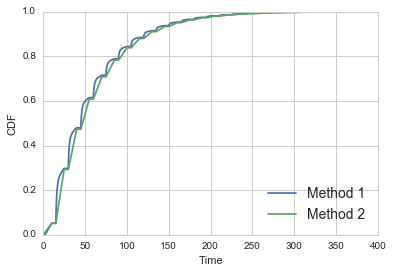

In [38]:
plt.plot(times_d, cdf_d, label='Method 1')
plt.plot(times_c, cdf_c, label='Method 2')
plt.legend(fontsize=14, loc=4)
plt.xlabel('Time')
plt.ylabel('CDF')
plt.savefig("tex/img/method1method2_difftimestep.pdf")